In [1]:
# Importing all the necessary libraries

import pandas as pd
import os, requests, json
from dotenv.main import load_dotenv
load_dotenv()
from spacy.training.example import Example
from spacy.util import minibatch
import random
import time
import matplotlib.pyplot as plt
import spacy
from sklearn.metrics import classification_report

In [2]:
train_data = pd.read_excel("MLTD.xlsx")

In [3]:
train_data

,Comments,hyper,layer,duplicate,model,performance
0,Adjusting the hyper learning rate for the opt...,1,0,0,0,0
1,Tuning hyper batch size for model training ef...,1,0,0,0,0
2,Experimenting with hyper number of epochs to ...,1,0,0,0,0
3,Setting the hyper regularization parameter to...,1,0,0,0,0
4,Optimizing the hyper kernel size for the conv...,1,0,0,0,0
...,...,...,...,...,...,...
2530,todo performance optimize this by only creatin...,0,0,0,0,1
2531,is added as it would likely degrade performance,0,0,0,0,1
2532,theres performance issues with a large amount ...,0,0,0,0,1
2533,a productionquality purepython wsgi server wit...,0,0,0,0,1


In [4]:
for col in list(train_data.columns)[1:]:
    print(col)
    print(train_data[col].value_counts()/train_data[col].value_counts().sum())
    print("-"*100)

hyper
0    0.949112
1    0.050888
Name: hyper, dtype: float64
----------------------------------------------------------------------------------------------------
layer
0    0.83432
1    0.16568
Name: layer, dtype: float64
----------------------------------------------------------------------------------------------------
duplicate
0    0.919132
1    0.080868
Name: duplicate, dtype: float64
----------------------------------------------------------------------------------------------------
model
1    0.566864
0    0.433136
Name: model, dtype: float64
----------------------------------------------------------------------------------------------------
performance
0    0.8643
1    0.1357
Name: performance, dtype: float64
----------------------------------------------------------------------------------------------------


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_data, test_size=0.2, stratify=train_data[['hyper', 'layer', 'duplicate','model','performance']])
for col in list(train.columns)[1:]:
    print(col)
    print(train[col].value_counts()/train[col].value_counts().sum())
    print("-"*100)

hyper
0    0.949211
1    0.050789
Name: hyper, dtype: float64
----------------------------------------------------------------------------------------------------
layer
0    0.83432
1    0.16568
Name: layer, dtype: float64
----------------------------------------------------------------------------------------------------
duplicate
0    0.919132
1    0.080868
Name: duplicate, dtype: float64
----------------------------------------------------------------------------------------------------
model
1    0.567061
0    0.432939
Name: model, dtype: float64
----------------------------------------------------------------------------------------------------
performance
0    0.864398
1    0.135602
Name: performance, dtype: float64
----------------------------------------------------------------------------------------------------


In [6]:
for col in list(test.columns)[1:]:
    print(col)
    print(test[col].value_counts()/test[col].value_counts().sum())
    print("-"*100)

hyper
0    0.948718
1    0.051282
Name: hyper, dtype: float64
----------------------------------------------------------------------------------------------------
layer
0    0.83432
1    0.16568
Name: layer, dtype: float64
----------------------------------------------------------------------------------------------------
duplicate
0    0.919132
1    0.080868
Name: duplicate, dtype: float64
----------------------------------------------------------------------------------------------------
model
1    0.566075
0    0.433925
Name: model, dtype: float64
----------------------------------------------------------------------------------------------------
performance
0    0.863905
1    0.136095
Name: performance, dtype: float64
----------------------------------------------------------------------------------------------------


In [7]:
train.set_index('Comments',inplace=True)

In [8]:
train_data = train[train==1].stack().reset_index().drop(0, axis=1)

In [9]:
## add textcat_multilabel to nlp.add_pipe
import spacy
nlp = spacy.blank('en')
textcat = nlp.add_pipe("textcat_multilabel", last=True)
## add your label
for i in train_data['level_1'].unique():
    textcat.add_label(i)


In [10]:
train_data_modified = []
for idx, row in train_data.iterrows():
    labels = {"hyper":False, "layer":False,"duplicate":False,"model":False, "performance":False}
    
    labels[row['level_1']] = True
    
    tup = (row['Comments'], {"cats":labels})
    train_data_modified.append(tup)

In [11]:
train_examples = []

for text, annotations in train_data_modified:
    train_examples.append(Example.from_dict(nlp.make_doc(text), annotations))

In [12]:
nlp.initialize()

In [13]:
losses_p = []

for i in range(50): # Number of training iterations
    random.shuffle(train_examples)
    losses = {}
    for batch in minibatch(train_examples, size=8): # Batch size
        nlp.update(batch, losses=losses) # Dropout rate
    print(i, "<---->", losses)
    losses_p.append(losses['textcat_multilabel'])

0 <----> {'textcat_multilabel': 16.368647577255615}
1 <----> {'textcat_multilabel': 7.8234638501689915}
2 <----> {'textcat_multilabel': 5.943508758386088}
3 <----> {'textcat_multilabel': 5.23469033325091}
4 <----> {'textcat_multilabel': 5.236597296152468}
5 <----> {'textcat_multilabel': 5.203903544890636}
6 <----> {'textcat_multilabel': 4.673333872134208}
7 <----> {'textcat_multilabel': 4.635924311513008}
8 <----> {'textcat_multilabel': 4.272245184220083}
9 <----> {'textcat_multilabel': 4.2968587444565856}
10 <----> {'textcat_multilabel': 4.087515916230586}
11 <----> {'textcat_multilabel': 4.0521949332651275}
12 <----> {'textcat_multilabel': 3.8078337496244785}
13 <----> {'textcat_multilabel': 3.798806857183081}
14 <----> {'textcat_multilabel': 3.6043009184277253}
15 <----> {'textcat_multilabel': 3.8276733571128716}
16 <----> {'textcat_multilabel': 3.5788411723615354}
17 <----> {'textcat_multilabel': 3.690019433296584}
18 <----> {'textcat_multilabel': 3.4182198793321277}
19 <----> {'te

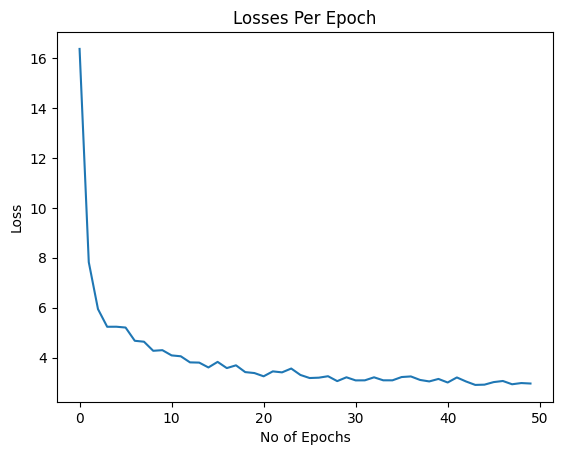

In [14]:
plt.plot(losses_p)
plt.title('Losses Per Epoch')
plt.xlabel('No of Epochs')
plt.ylabel('Loss');

In [15]:
nlp.to_disk('my_model_no_dropout')

In [16]:
test

,Comments,hyper,layer,duplicate,model,performance
2096,todo this test is a little awkward the smiles2...,0,0,0,1,0
1728,todo fix and add model name to supervised,0,0,0,1,0
861,the hyphenationsyllabification algorithm is ...,0,0,0,1,0
1059,the codelearn module provides tools that mak...,0,0,0,1,0
571,todo this class is mostly duplicate from evalu...,0,0,1,0,0
...,...,...,...,...,...,...
2502,work around torcheinsum performance issues,0,0,0,0,1
1261,model fitting on imbalanced dataset and co...,0,0,0,1,0
72,Selecting the hyper boosting type for model t...,1,0,0,0,0
90,Selecting the hyper dimensionality_reduction ...,1,0,0,0,0


In [17]:
test.set_index('Comments',inplace=True)

In [18]:
test = test[test==1].stack().reset_index().drop(0, axis=1)

In [19]:
test['Prediction'] = ''

In [20]:
nlp = spacy.load('my_model_no_dropout')
for idx, row in test.iterrows():
        comment = test.loc[idx, 'Comments']
        doc = nlp(comment)
        preds = sorted(doc.cats.items(), key = lambda kv: -kv[1])[0][0]
        test.loc[idx, 'Prediction'] = preds

In [21]:
from sklearn.metrics import classification_report
print(classification_report(test['level_1'], test['Prediction']))

              precision    recall  f1-score   support

   duplicate       0.90      0.88      0.89        41
       hyper       1.00      0.88      0.94        26
       layer       0.84      0.88      0.86        84
       model       0.92      0.93      0.92       287
 performance       0.78      0.75      0.76        69

    accuracy                           0.89       507
   macro avg       0.89      0.86      0.88       507
weighted avg       0.89      0.89      0.89       507



In [40]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test['level_1'], test['Prediction']))

[[ 36   0   2   1   2]
 [  0  23   2   0   1]
 [  0   0  74   7   3]
 [  3   0   9 266   9]
 [  1   0   1  15  52]]


In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Your code to obtain the confusion matrix
conf_matrix = confusion_matrix(test['level_1'], test['Prediction'])

# Get the class names
class_names = np.unique(test['level_1'])

# Create a DataFrame with the confusion matrix values and class names
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
             duplicate  hyper  layer  model  performance
duplicate           36      0      2      1            2
hyper                0     23      2      0            1
layer                0      0     74      7            3
model                3      0      9    266            9
performance          1      0      1     15           52
